In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import pickle

In [2]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
sys.path.append('/home/jiaxuanl/Research/Packages/carpenter/src/')
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70)

from carpenter.display import display_merian_cutout_rgb
from carpenter.utils import SBP_star

In [91]:
kuaizi.set_matplotlib(style='JL', fontsize=15, dpi=70, usetex=True)

In [5]:
channels = list('grizy') + ['N708', 'N540']

In [114]:
gaap_cat = Table.read('./Catalogs/dr1_wide/hsc_dr4_9813_merian_matched_p30p60_pts_clean.fits')#[:500]

In [115]:
# for filt in ['N708', 'N540']:
#     for ap in ['0_5', '0_7', '1_0', '1_5', '2_5', '3_0']:
#         gaap_cat.rename_column(f'{filt}_ext_gaap_GaapFlux_1_15x_{ap}_instFlux', 
#                                f'{filt}_gaap{ap.replace("_", "p")}Flux')
lookup = {'3_3': '11', '4_5': '15', '6_0': '20'}
for filt in ['N708', 'N540']:
    for i in [0, 1, 2]:
        for j in ['3_3', '4_5', '6_0']:
            gaap_cat.rename_column(f'{filt}_ext_convolved_ConvolvedFlux_{i}_{j}_instFlux', 
                                   f'{filt}_convolvedflux_{i}_{lookup[j]}_flux')
            
for filt in ['N708', 'N540']:
    for i in [0, 1, 2]:
        for j in ['3_3', '4_5', '6_0']:
            gaap_cat[f'{filt}_convolvedflux_{i}_{lookup[j]}_mag'] = -2.5 * np.log10(gaap_cat[f'{filt}_convolvedflux_{i}_{lookup[j]}_flux']) + (26.9)


In [116]:
for aper in ['1p0', '1p5', '2p5', '3p0']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

for i in [0, 1, 2]:
    for aper in ['11', '15', '20']:
        gaap_cat[f'conv_mag_{i}_{aper}'] = np.hstack(
            [gaap_cat[f'{filt}_convolvedflux_{i}_{aper}_mag'].data[:, None] for filt in list('grizy') + ['N708', 'N540']])

In [117]:
flag = ((gaap_cat['gaap_mag_1p0'][:, 0] - gaap_cat['gaap_mag_1p0'][:, -1]) > 0)
gaap_cat = gaap_cat[flag]

In [118]:
len(gaap_cat)

571

Text(0.5, 0.92, '$\\texttt{GAAP1p0}$ v.s. $\\texttt{PSF}$, native pixel')

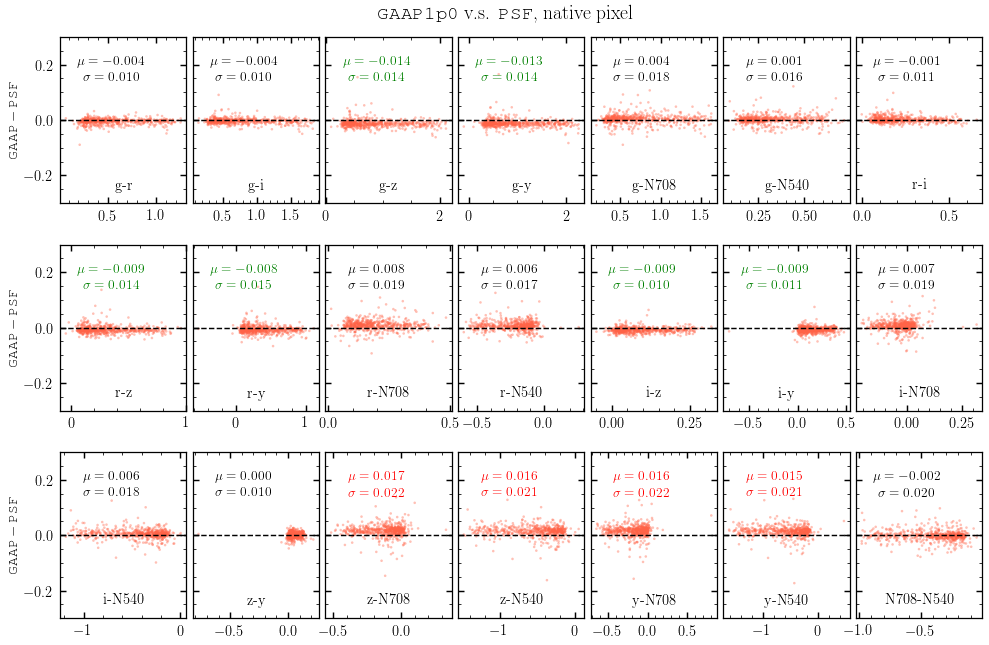

In [95]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = gaap_cat['psf_mag'][:, filt1] - gaap_cat['psf_mag'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=7, color='tomato', alpha=0.4,
                label=aper, edgecolors='none')
    _mean = np.nanmedian(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.3, 0.3)
    plt.text((xlim[0] + xlim[1]) / 2, -0.25, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.2, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.14, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{PSF}$')

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{GAAP' + aper + r'}$ v.s. $\texttt{PSF}$, native pixel', y=0.92, fontsize=20)

# plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_psf_tractor_comp.png', bbox_inches='tight', dpi=70)

Text(0.5, 0.92, '$\\texttt{ConvFlux_2_20}$ v.s. $\\texttt{PSF}$, native pixel')

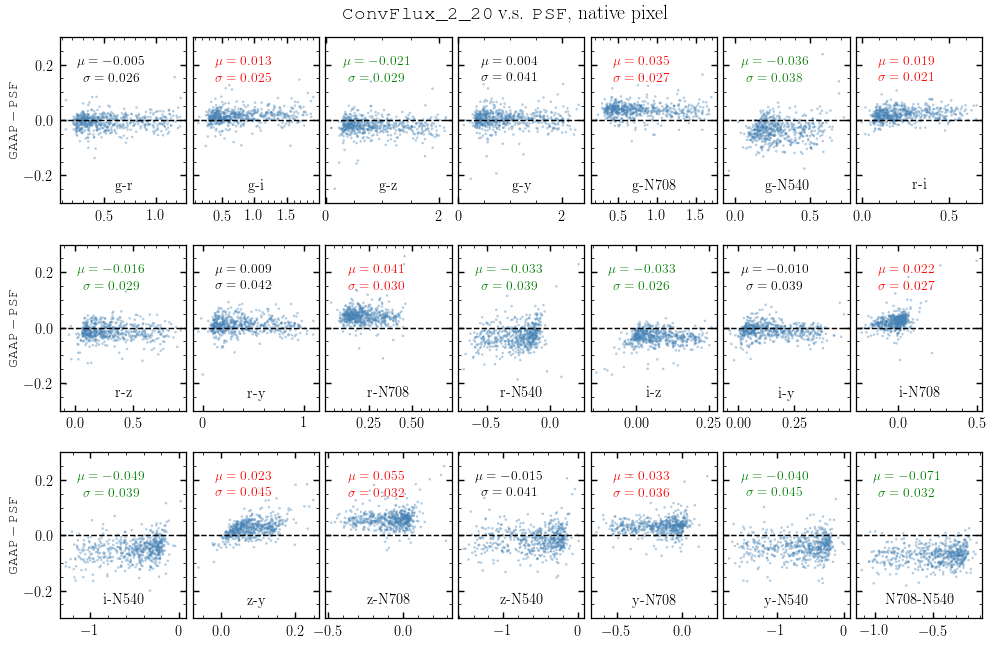

In [170]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '20'
    conv = '2'
    color1 = gaap_cat[f'conv_mag_{conv}_{aper}'][:, filt1] - gaap_cat[f'conv_mag_{conv}_{aper}'][:, filt2]
    color2 = gaap_cat['psf_mag'][:, filt1] - gaap_cat['psf_mag'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=7, color='steelblue', alpha=0.4,
                label=aper, edgecolors='none')
    _mean = np.nanmedian(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.3, 0.3)
    plt.text((xlim[0] + xlim[1]) / 2, -0.25, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.2, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.14, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{PSF}$')

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{ConvFlux' + f'_{conv}_{aper}' + r'}$ v.s. $\texttt{PSF}$, native pixel', y=0.92, fontsize=20)

# plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_psf_tractor_comp.png', bbox_inches='tight', dpi=70)

Text(0.5, 0.92, '$\\texttt{ConvFlux_2_15}$ v.s. $\\texttt{GAAP 1p0}$, native pixel')

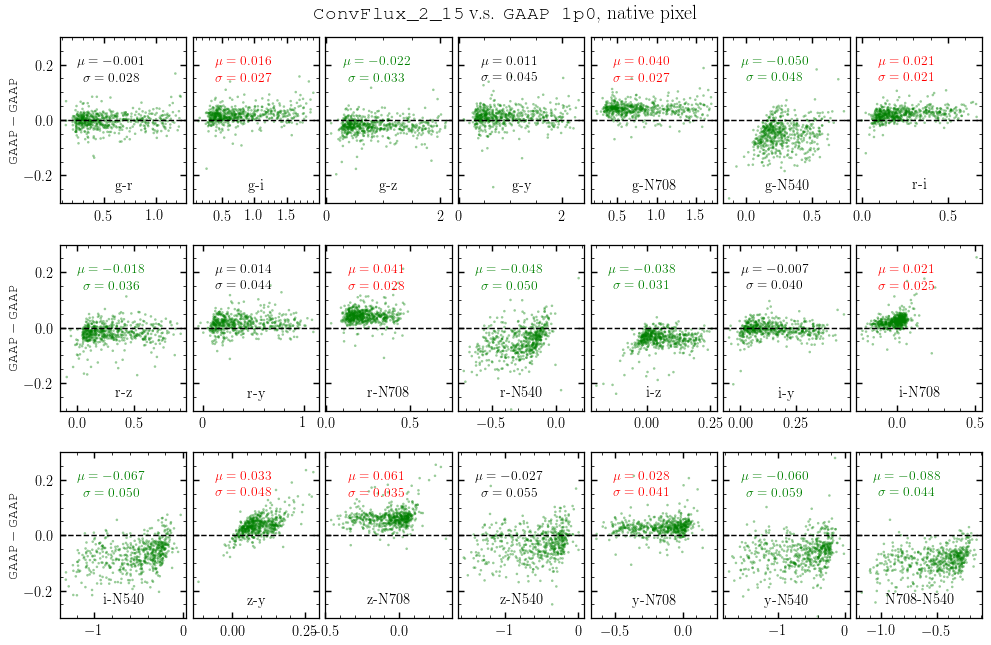

In [142]:
# all colors
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11), sharey=True)

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '15'
    conv = '2'
    color1 = gaap_cat[f'conv_mag_{conv}_{aper}'][:, filt1] - gaap_cat[f'conv_mag_{conv}_{aper}'][:, filt2]
    color2 = gaap_cat['gaap_mag_1p0'][:, filt1] - gaap_cat['gaap_mag_1p0'][:, filt2]
    plt.scatter(color1, color1 - color2,
                s=7, color='green', alpha=0.4,
                label=aper, edgecolors='none')
    _mean = np.nanmedian(color1 - color2)
    _std = np.nanstd(color1 - color2)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(0, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.3, 0.3)
    plt.text((xlim[0] + xlim[1]) / 2, -0.25, 
             channels[filt1] + '-' + channels[filt2], 
             ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.2, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.14, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i % 7 == 0:
        plt.ylabel(r'$\texttt{GAAP} - \texttt{GAAP}$')

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle(r'$\texttt{ConvFlux' + f'_{conv}_{aper}' + r'}$ v.s. $\texttt{GAAP 1p0}$, native pixel', y=0.92, fontsize=20)

# plt.savefig('/tigress/jiaxuanl/public_html/Merian/stars/stars_psf_tractor_comp.png', bbox_inches='tight', dpi=70)

Text(0.5, 0.98, '$\\texttt{PSF}$ v.s. $\\texttt{ConvFlux_0_15}$')

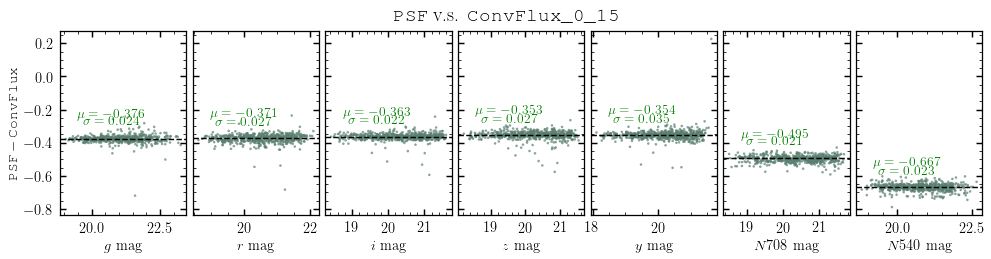

In [137]:
# all colors
fig, axes = plt.subplots(1, 7, figsize=(17, 3.5), sharey=True)

for i, filt in enumerate(channels):
    plt.sca(axes[i])
    conv = '0'
    aper = '15'
    diff = gaap_cat['psf_mag'][:, i] - gaap_cat[f'conv_mag_{conv}_{aper}'][:, i]
    plt.scatter(gaap_cat['psf_mag'][:, i], diff,
                s=7, color='#5A7F71', alpha=0.7,
                label=aper, edgecolors='none')
    _mean = np.nanmedian(diff)
    _std = np.nanstd(diff)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(_mean, color='k', ls='--')
    plt.xlim(*xlim)
#     plt.ylim(-0.2 + _mean, 0.2 + _mean)
#     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
#              channels[filt], 
#              ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.13 + _mean, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.08 + _mean, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i == 0:
        plt.ylabel(r'$\texttt{PSF} - \texttt{ConvFlux}$')
    
    plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{PSF}$ v.s. $\texttt{ConvFlux' + f'_{conv}_{aper}' + '}$', fontsize=20)

In [152]:
gaap_cat[f'psf2_mag'] = np.hstack(
        [gaap_cat[f'{filt}_psfflux_mag'].data[:, None] - 0.4 for filt in list('grizy')])

Text(0.5, 0.98, '$\\texttt{PSF}$ v.s. $\\texttt{psfflux_DR4}$')

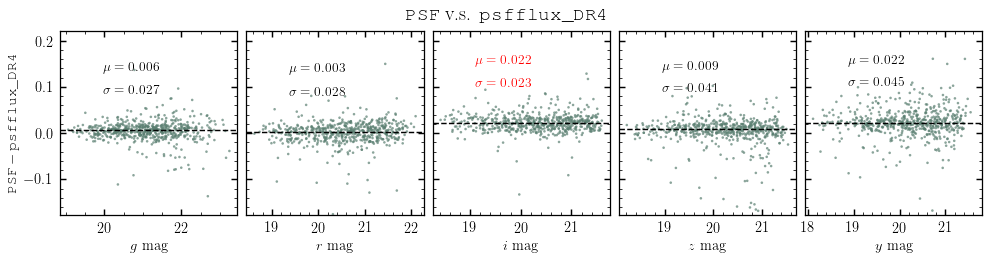

In [155]:
# all colors
fig, axes = plt.subplots(1, 5, figsize=(17, 3.5), sharey=True)

for i, filt in enumerate(list('grizy')):
    plt.sca(axes[i])
    conv = '0'
    aper = '15'
    diff = gaap_cat['psf_mag'][:, i] - gaap_cat['psf2_mag'][:, i]
    plt.scatter(gaap_cat['psf_mag'][:, i], diff,
                s=7, color='#5A7F71', alpha=0.7,
                label=aper, edgecolors='none')
    _mean = np.nanmedian(diff)
    _std = np.nanstd(diff)
    
    xlim = plt.gca().get_xlim()
    plt.axhline(_mean, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(-0.2 + _mean, 0.2 + _mean)
#     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
#              channels[filt], 
#              ha='center', fontsize=15)
    if np.abs(_mean / _std) > 0.5:
        textcolor = 'r' if _mean > 0 else 'g'
    else:
        textcolor = 'k'
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.13 + _mean, 
             f'$\mu= {_mean:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.08 + _mean, 
             f'$\sigma= {_std:.3f}$',
             ha='center', fontsize=14, color=textcolor)
    
    if i == 0:
        plt.ylabel(r'$\texttt{PSF} - \texttt{psfflux_DR4}$')
    
    plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$')
    
plt.subplots_adjust(wspace=0.05, hspace=0.28)
plt.suptitle(r'$\texttt{PSF}$ v.s. $\texttt{psfflux_DR4}$', fontsize=20)

In [172]:
(-2.5 * np.log10(gaap_cat['g_psfFlux']) - gaap_cat['g_psfflux_mag']).mean()

-31.395804380836026

In [173]:
(-2.5 * np.log10(gaap_cat['i_psfFlux']) - gaap_cat['i_psfflux_mag']).mean()

-31.37821219255755

In [174]:
(-2.5 * np.log10(gaap_cat['z_psfFlux']) - gaap_cat['z_psfflux_mag']).mean()

-31.398471047389275

In [158]:
# ZP of convflux: 26.9
# ZP of gaapflux: 26.6

4.399999999999999

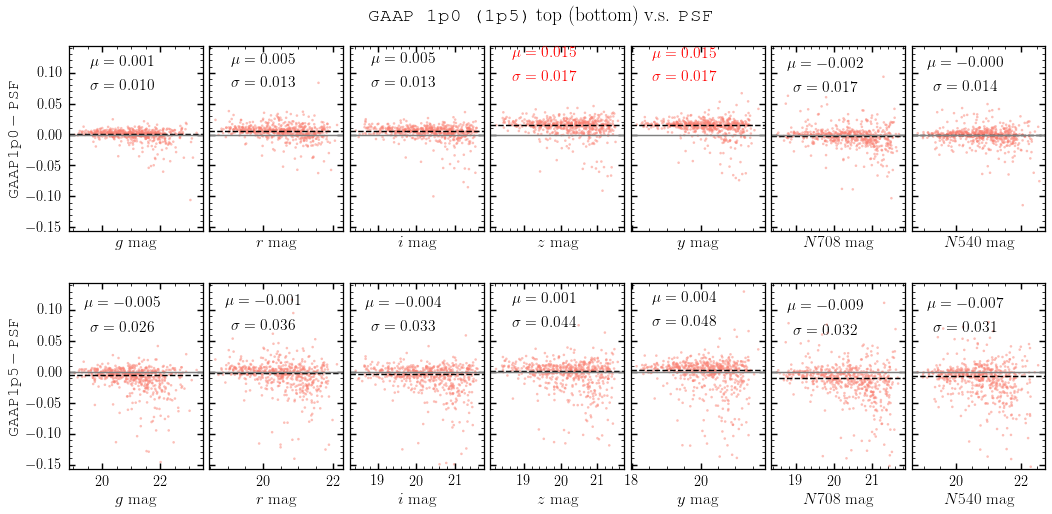

In [96]:
# all colors
p0_mag = {}

fig, axes = plt.subplots(2, 7, figsize=(18, 8), sharey=True, sharex='col')


for k, aper in enumerate(['1p0', '1p5']):
    for i, filt in enumerate(channels):
        plt.sca(axes[k, i])

        diff = gaap_cat[f'gaap_mag_{aper}'][:, i] - gaap_cat['psf_mag'][:, i]
        plt.scatter(gaap_cat[f'gaap_mag_{aper}'][:, i], diff,
                    s=7, color='salmon', alpha=0.5,
                    label=aper, edgecolors='none')

        _mean = np.nanmedian(diff)
        _std = np.nanstd(diff)
        p0_mag[filt] = _mean

        xlim = plt.gca().get_xlim()
        plt.axhline(_mean, color='k', ls='--')
        plt.axhline(0, color='gray', ls='-')
        plt.xlim(*xlim)
        plt.ylim(-0.15 + _mean, 0.15 + _mean)
    #     plt.text((xlim[0] + xlim[1]) / 2, -0.4 + _mean, 
    #              channels[filt], 
    #              ha='center', fontsize=15)
        if np.abs(_mean / _std) > 0.5:
            textcolor = 'r' if _mean > 0 else 'g'
        else:
            textcolor = 'k'
        plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.11 + _mean, 
                 f'$\mu= {_mean:.3f}$',
                 ha='center', fontsize=16, color=textcolor)
        plt.text((xlim[0] * 0.6 + xlim[1] * 0.4), 0.07 + _mean, 
                 f'$\sigma= {_std:.3f}$',
                 ha='center', fontsize=16, color=textcolor)

        if i == 0:
            plt.ylabel(r'$\texttt{GAAP' + aper + r'} - \texttt{PSF}$', fontsize=17)

        plt.xlabel('$' + channels[i] + '\ \mathrm{mag}$', fontsize=17)

plt.suptitle(r'$\texttt{GAAP 1p0 (1p5)}$ top (bottom) v.s. $\texttt{PSF}$', fontsize=20, y=0.95)
plt.subplots_adjust(wspace=0.05, hspace=0.28)